### 1. Biased-Persistent motion

A BP walker is defined by three parameters $w, p$ and $b$. At each time step biased motion is chosen with probability $w$ and persistent with probability $1-w$. An angle is draw from the distribution 

$$
N_{\text{w}} ( \alpha_t | \, \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \sum_{k=-\infty}^{\infty} \exp \big[ - \frac{(\alpha_{t} - \mu + 2 \pi k)^{2}}{2 \sigma ^{2}
} \big].
$$

If biased motion occurs then $\mu = \beta_t$ and $\sigma = - 2\log(b)$. If persistent motion occurs, then $\mu = \alpha_{t-1}$ and $\sigma = - 2\log(p)$


### 2. Inference on biased-persistent trajectories

This notebook describes how you can do basic MCMC inference on biased-persistent trajectory data. The likelihood function, for a set of parameters $\Theta$ given $N$ sets of trajectories $\{ \pi_i \}$ is given as 

$$
L(\Theta) = \prod^{N}_{i=0} p\,(\pi_{i} \,|\, \Theta)
$$

Converting this path $\pi_i$ into a set of angle observations $\alpha^{i}_{t}$ and holding simulteneously the direction to the source at each step $\beta^{i}_{t}$ one can break down this probability into 

$$
p\,(\pi_{i} \,|\, \Theta) = \underbrace{p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} )}_{\text{only biased motion possible}} \, \prod^{T}_{t=1} \underbrace{p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) }_{\text{biased or persistent motion possible}}. 
$$

Note that on the first step only biased motion is possible, that is 

$$
p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) =  N_{\text{w}} ( \alpha^{i}_{0} \, | \, \beta^{i}_{0}, \, \sigma_{b})
$$

and 

$$
p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) = w N_{\text{w}} ( \alpha^{i}_{t} \, | \, \beta^{i}_{t}, \, \sigma_{b}) + (1-w)N_{\text{w}} ( \alpha^{i}_{t} \, | \, \alpha_{t-1}^{i}, \, \sigma_{p}).
$$

where $N_{\text{w}}$ is the wrapped normal distribution as defined in section 1. 



### 3. MCMC

With a set of starting parameters $\Theta_0$ one can successively update and get a stationary distribution by applying Markov Chain Monte Carlo algorithms. The Metropolis Hastings version has an update probability 

$$
P(\Theta \rightarrow \Theta') = \text{min} \Big( 1, \, \frac{L(\Theta')\,  q(\Theta)}{L(\Theta) \, q(\Theta')} \Big)
$$

where $\Theta'$ is a randomly chosen move in some direction in parameter space and $q(\Theta)$ is a prior. This could simply be a uniform distribution over the interval $[0, 1]$ for each of $w, p, b$. In this case the update rule would become

$$
P(\Theta \rightarrow \Theta') = \begin{cases}
    0, & \text{if $w, p$ or $b$ outside of $[0, 1]$}.\\
    \text{min} \Big( 1, \, \frac{L(\Theta')}{L(\Theta)} \Big), & \text{otherwise}.
  \end{cases} 
$$

### 4. Numerical stability

The multiplication together of many probabilities gets very small very quickly. We can get around this by using logarithms. Note that 

$$
\begin{align}
\log \big( L(\Theta) \big) &= \log \big( \prod^{N}_{i=0} p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \, \prod^{T}_{t=1} p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \Big) \\
&= \sum_{i=0}^{N} \log \Big(  p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \, \prod^{T}_{t=1} p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \Big)\\
&= \sum_{i=0}^{N} \Big[ \log \big( p\,(\alpha^{i}_{0} \, | \, \Theta, \, \beta^{i}_{0} ) \big) + \, \sum^{T}_{t=1} \log \big( p \, (\alpha^{i}_{t} \, | \, \Theta, \, \alpha^{i}_{t-1}, \, \beta^{i}_{t} ) \big) \Big]
\end{align}
$$

Then when evaluating the fraction in the MCMC update, 

$$
\begin{align}
\frac{L(\Theta')}{L(\Theta)} &= \frac{\exp \big( \log ( L(\Theta') ) \big) }{\exp \big( \log ( L(\Theta) ) \big) } \\
&= \exp \big( \log ( L(\Theta') ) - \log ( L(\Theta) ) \big)
\end{align}
$$

So we can recover the fraction we need without having to lose precision with the multiplication of many many probabilities

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook
np.set_printoptions(precision=6, linewidth=500, threshold=500, suppress=True)

In [3]:
import os
import sys
import time
sys.path.append(os.path.abspath('..'))

from utils.distributions import wrapped_normal_sample, bernoulli, truncated_normal_sample
from utils.plotting import add_pi_ticks
from utils.angles import angle_between

### 5. Set up a basic source model

It directs all movement towards the origin

In [27]:
# THIS IS MY SUPER BASIC SOURCE DEFINITION
source_coords = np.array([0, 0])

# use negative y-axis as the reference axis. All angles will be measured against this
reference_axis = np.array([0, -1]) 

# super simple source model
def direction_to_source(coords: np.array) -> np.array:
    return source_coords - coords

### 6. Set up a basic biased-persistent random walker

In [6]:
def BP_walk(X0: np.array, T: int, w: float, p: float, b:float) -> np.array:
    """
    Perform a biased-persistent random walk from starting point X0, for T time steps
    with parameters w, p, b.
    
    Returns:
        np.array (T+1, 2): the x-y coordinates of the path traversed beginning at X0
    """

    path = np.zeros((T + 1, 2))
    path[0, :] = X0
    biased = bernoulli(w, T)  # pre-determine all the b/p decisions in vector form

    sig_b = -2 * np.log(b)
    sig_p = -2 * np.log(p)

    for i, bias in enumerate(biased):
        current_position = path[i]
        dir_to_source = direction_to_source(current_position)

        if bias or i == 0:
            sig = sig_b
            mu = angle_between(reference_axis, dir_to_source)
        else:
            sig = sig_p
            mu = previous_angle
        if np.isinf(sig):
            sig = 100

        alpha = wrapped_normal_sample(mu, sig)
        previous_angle = alpha
        s = truncated_normal_sample(0.2)
        dx = s * np.sin(alpha)
        dy = s * np.cos(alpha)
        path[i + 1, 0] = path[i, 0] + dx
        path[i + 1, 1] = path[i, 1] - dy 

    return path

### 7. Generate some walker trajectories

<IPython.core.display.Javascript object>


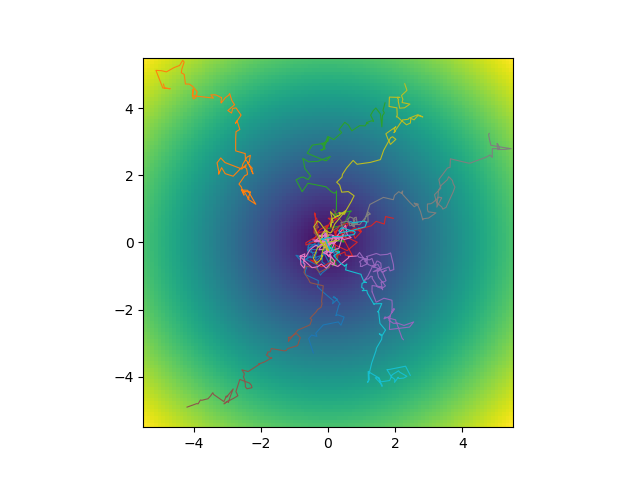

In [55]:
n_walkers = 10
T = 100
w = 0.3
b = 0.7
p = 0.5

paths = np.concatenate([BP_walk(np.random.uniform(-5, 5, size=(2,)), T, w, p, b)[:, :, None] for i in range(n_walkers)], axis=2)

plt.figure()
X, Y = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
f = (X ** 2 + Y ** 2) ** 0.5
plt.imshow(f, extent=(-5.5, 5.5, -5.5, 5.5))
for i in range(n_walkers):
    plt.plot(paths[:, 0, i], paths[:, 1, i], linewidth=0.8)

### 8. Write a vectorised function for evaluating wrapped normal pdf

<IPython.core.display.Javascript object>


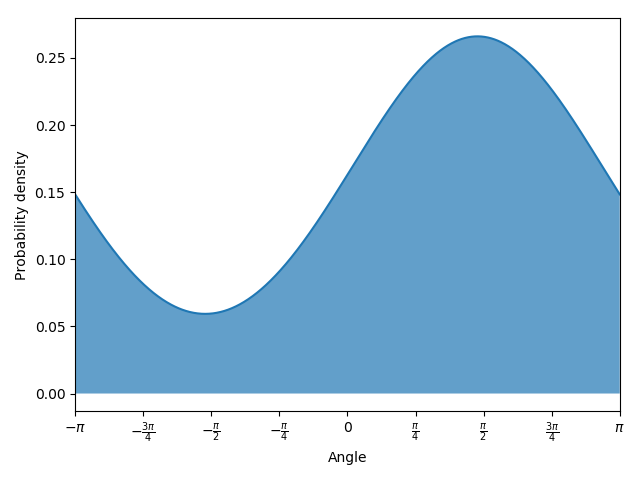

In [52]:
def normal_pdf(x: np.array, mu: np.array, sig: np.array) -> np.array:
    """
    Get the value of the normal distribution pdf function for set of points x.
    """
    return (1 / (sig * (2 * np.pi) ** 0.5)) * np.exp(- (x - mu) ** 2 / (2 * sig ** 2))

def wrapped_normal_pdf(x: np.array, mu: np.array, sig: float) -> np.array:
    """
    For a set of points x, get the value of the probability density
    function for a wrapped normal distribution at these points. 
    Each point in x can come from a distribution with a different
    mean, but all distributions must have the same variance. Hence
    mu can be a numpy array, but sig must be a float. 
    """

    # if sigma is greater than 6, the difference between it and a uniform distribution is ~1e-8
    if sig > 6:
        if isinstance(x, np.ndarray):
            return np.ones_like(x) / (2 * np.pi)
        else:
            return 1 / (2 * np.pi)
    if sig == 0:
        return mu

    # *blindly* opt for 5 loops either side
    
    # mu =  [ mu1   ,  mu2   ,  mu3   ,  mu4   ]
    
    #          .        .        .        .
    #          .        .        .        .
    # X =   [a - 2pi, b - 2pi, c - 2pi, d - 2pi] 
    #       [   a   ,    b   ,    c   ,    d   ]
    #       [a + 2pi, b + 2pi, c + 2pi, d + 2pi]
    #       [a + 4pi, b + 4pi, c + 4pi, d + 4pi]
    #          .        .        .        .
    #          .        .        .        .

    # then sum(normal(X, mu=mu), axis=0)

    return normal_pdf(np.array([x + 2 * np.pi * i for i in range(-4, 5)]), mu, sig).sum(0)

fig, ax = plt.subplots()
x = np.linspace(-np.pi, np.pi, 1001)
y = wrapped_normal_pdf(x, 1.5, 1.5)
plt.plot(x, y)
plt.xlim((-np.pi, np.pi))
ax.fill_between(x, 0, y, alpha=0.7)
add_pi_ticks(ax)
plt.xlabel('Angle')
plt.ylabel('Probability density')
plt.tight_layout()

### 9. Set up an inference pipeline

In [14]:
class BPbayesian:

    def __init__(self, paths: np.array, direction_to_source: object):

        """
        Params:

            paths:                np.array - (T+1, 2, N) - paths of N walkers walking for T timesteps
            direction_to_source:  a function that takes array([x, y]) and returns the direction to the source.

        """

        self.paths = paths
        self.direction_to_source = direction_to_source
        alphas, betas = self.convert_path(paths)
        self.alphas = alphas
        self.betas = betas

    def convert_path(self, paths: np.array):
        """
        Given a set of raw x-y coordinates, get a list of the alphas and betas

        Params:

            paths:                np.array - (T+1, 2, N) - paths of N walkers walking for T timesteps
            reference_axis:       np.array - (2, ) direction which angles should be measured around
            direction_to_source:  a function that takes array([x, y]) and returns the direction to the source.

        Returns:

            alphas:    np.array - (T, N): angle taken at each time step
            betas:     np.array - (T, N): direction to source at each time step

        """

        moves = paths[1:, :, :] - paths[:-1, :, :]
        alphas = np.apply_along_axis(lambda move: angle_between(reference_axis, move), 1, moves)
        d_to_sources = np.apply_along_axis(self.direction_to_source, 1, paths)
        betas = np.apply_along_axis(lambda d: angle_between(reference_axis, d), 1, d_to_sources)[:-1, :]

        return alphas, betas

    def log_likelihood(self, w: float, p: float, b: float) -> float:
        """
        Get the log-likelihood of a set of parameters w, p, b. This is a vectorised version which
        is considerably faster.

        Params:

            w:    The variable w which defines the probability of taking a biased step
            p:    The variable p, defining the variance of persistent motion
            b:    The variable b, defining the variance of boased motion

        Returns:

            alphas:    np.array - (T, N): angle taken at each time step
            betas:     np.array - (T, N): direction to source at each time step

        """

        sig_b = -2 * np.log(b)
        sig_p = -2 * np.log(p)
        log_prob = 0

        for walker in range(self.alphas.shape[1]):

            alphas = self.alphas[1:, walker]
            alpha_prevs = self.alphas[:-1, walker]
            betas = self.betas[1:, walker]

            p_0 = wrapped_normal_pdf(self.alphas[0, walker], self.betas[0, walker], sig_b)
            p_t = w * wrapped_normal_pdf(alphas, betas, sig_b) + (1 - w) * wrapped_normal_pdf(alphas, alpha_prevs, sig_p)

            log_prob += np.log(p_0)
            log_prob += np.log(p_t).sum()

        return log_prob

    def infer(self, w0: float, p0: float, b0: float,
              step: float=0.02,
              n_steps: int=10000,
              burn_in: int=3000) -> np.array:
        """
        Given a set of starting parameters, perform MCMC bayesian inference for n_steps with 
        a burn in of burn_in and a maximum step size in each direction of step_size
        
        Params:

            w0:    The starting point for w
            p0:    The starting point for p
            b0:    The starting point for b

        Returns:

            params:    np.array, shape: (n_steps - burn_in, 3) -> the disrtribution over parameters
        """

        params = []
        w, p, b = w0, p0, b0
        L0 = self.log_likelihood(w, p, b)

        for i in range(n_steps):

            # add random purturbation to w, p, b
            dw = np.random.uniform(-step, step)
            dp = np.random.uniform(-step, step)
            db = np.random.uniform(-step, step)
            w_, p_, b_ = w + dw, p + dp, b + db

            # Here, were essentially putting a uniform prior over w, p, b
            if any([a_ > 1 or a_ < 0 for a_ in [w_, b_, p_]]):
                continue
            
            # evaluate the log-likelihood of our proposed move
            L_p = self.log_likelihood(w_, p_, b_)
            
            # evaluate the probability of moving
            prob = np.exp(L_p - L0)
            
            # decide whether to move
            if np.random.uniform(0, 1) < prob:
                w, p, b = w_, p_, b_
                L0 = L_p
            if i > burn_in:
                params.append([w, p, b])

        return np.array(params)
    

### 10. RUN

In [59]:
BI = BPbayesian(paths, direction_to_source)

w0 = np.random.uniform(0, 1)
p0 = np.random.uniform(0, 1)
b0 = np.random.uniform(0, 1)

print('w0: {:.2f}, p0: {:.2f}, b0: {:.2f}'.format(w0, p0, b0))

w0: 0.17, p0: 0.36, b0: 0.17


In [60]:
t1 = time.time()
params = BI.infer(w0, p0, b0,
                    n_steps=10000,
                    burn_in=3000)
t2 = time.time()

print('Inference took : {:.2f}s'.format(t2 - t1))

Inference took : 11.84s


### 11. PLOT

Remember, the true walker was defined with parameters $w=0.3, p=0.7, b=0.7$

<IPython.core.display.Javascript object>


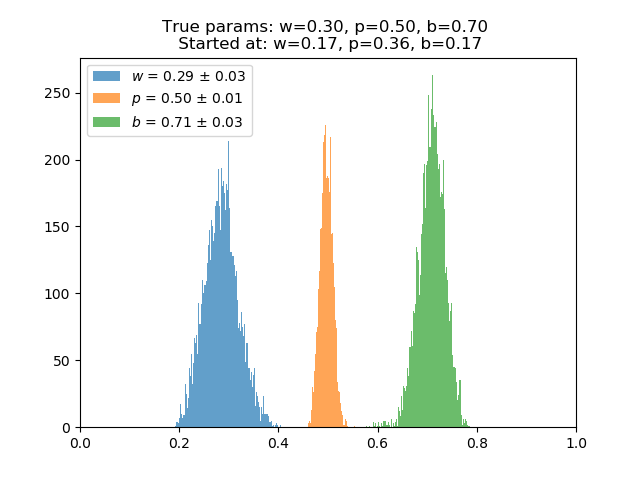

In [61]:
def plot(params: np.array, title: str=None):
    """
    params: np.array, shape: (n_steps - burn_in, 3) -> the parameters observed 
    """

    plt.figure()
    stds = np.std(params, 0)
    means = np.mean(params, 0)

    for i, typ in enumerate(['w', 'p', 'b']):
        plt.hist(params[:, i], label='${}$ = {:.2f} $\pm$ {:.2f}'.format(typ, means[i], stds[i]), bins=100, alpha=0.7)

    plt.legend()
    plt.xlim(0, 1)
    plt.title(title)

# plot(params1, title='Looped')
plot(params, title='True params: w={:.2f}, p={:.2f}, b={:.2f} \n Started at: w={:.2f}, p={:.2f}, b={:.2f}'.format(w, p, b, w0, p0, b0))
plt.savefig('inference2.png')

In [51]:
isinstance(np.zeros(4), vnp.ndarray)

True

In [46]:
type(np.array([]))

numpy.ndarray

In [47]:
np.ndarray

numpy.ndarray